Text(0.5,0.98,'Number of paper published in each month')

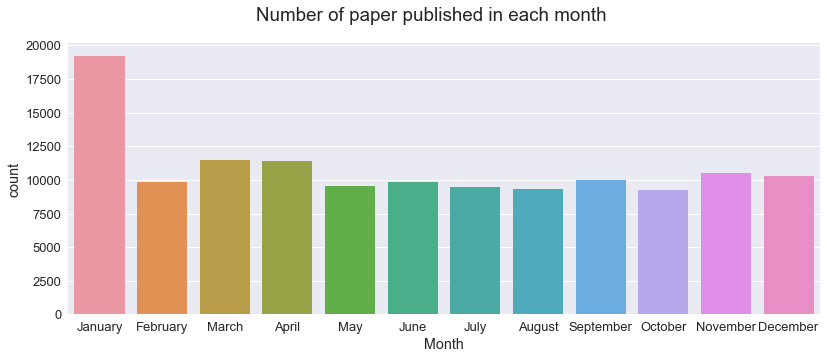

In [2]:
# paper publication around a year
plt.figure(figsize=(12,5))
sns.set(style="darkgrid",font_scale=1.3)
ax = sns.countplot(x="Month", data=df)
ax.set_xticklabels(["January","February","March", "April", "May", "June", "July", "August", "September", "October","November", "December"])
plt.suptitle("Number of paper published in each month")

In [86]:
max(df.Number_Of_authors)

500

In [128]:
import json
import ast
# obj = json.loads("[{'AuId': 2168721218, 'S': 1, 'AuN': 'emelia j benjamin'},]")
obj = ast.literal_eval(df["Authors"][24093])
print(len(obj))
print(json.dumps(obj[0], indent=2))
universities = { _obj["AfN"] for _obj in obj if "AfN" in _obj}
print(universities)

In [ ]:
df[]

In [120]:
df["Authors"][0]

"[{'AuId': 2168721218, 'S': 1, 'AuN': 'emelia j benjamin'}, {'AuId': 2005352543, 'S': 2, 'AuN': 'michael j blaha'}, {'AuId': 104634994, 'S': 3, 'AuN': 'stephanie e chiuve'}, {'AuId': 2046859330, 'S': 4, 'AuN': 'mary cushman'}, {'AuId': 2277451764, 'S': 5, 'AuN': 'sandeep r das'}, {'AuId': 1975017443, 'S': 6, 'AuN': 'rajat deo'}, {'AuId': 1959621794, 'S': 7, 'AuN': 'sarah d de ferranti'}, {'AuId': 2101491348, 'S': 8, 'AuN': 'james s floyd'}, {'AuId': 108138892, 'S': 9, 'AuN': 'myriam fornage'}, {'AuId': 2127140094, 'S': 10, 'AuN': 'cathleen gillespie'}, {'AuId': 1772048951, 'S': 11, 'AuN': 'carmen r isasi'}, {'AuId': 2166150345, 'S': 12, 'AuN': 'monik c jimenez'}, {'AuId': 2189981646, 'S': 13, 'AuN': 'lori c jordan'}, {'AuId': 2141707827, 'S': 14, 'AuN': 'suzanne e judd'}, {'AuId': 2894344593, 'S': 15, 'AuN': 'daniel t lackland'}, {'AuId': 2168694049, 'S': 16, 'AuN': 'judith h lichtman'}, {'S': 17, 'AuId': 304513337, 'AfN': 'university of michigan', 'AfId': 27837315, 'AuN': 'lynda d lis

In [25]:
outlink_map = {}
inlink_map = {}
df_new = df[df["References"].notnull()]
for index, row in df_new.iterrows():
    ref = row["References"]
    ref_list = list(map(int,ref.strip("[]'").split(",")))
    outlink_map[row["Id"]] = ref_list
    for ref in ref_list:
        listi = inlink_map.get(ref, [])
        listi.append(row["Id"])
        inlink_map[ref] = listi

In [ ]:
def calculate_page_rank():
    count = 0
    page_year = {row["Id"]:row["Year"] for _t, row in df.iterrows()}
    year_citation_count = { page_year[index]:0 for index in page_year}
    year_paper_count = { page_year[index]:0 for index in page_year}
    avg_year_citation_count = {}
    for index in page_year:
        year = page_year[index]
        len_outlink = len(outlink_map.get(index, []))
        if len_outlink > 0:
            year_citation_count[year] += len_outlink
            year_paper_count[year] += 1
    for year in year_citation_count:
        if year_paper_count[year] > 0:
            avg_year_citation_count[year] = year_citation_count[year]/year_paper_count[year]
    page_rank = {}
    updated_page_rank = {}
    for index in df["Id"]:
        page_rank[index] = 1
    while True:
        count += 1
        flag = True
        for key in page_rank:
            cs = page_rank[key]
            if key in inlink_map:
                inlink_list = inlink_map[key]
                ns = 0
                for link in inlink_list:
                    if link in page_rank and link in outlink_map:
                        ns += page_rank[link]/len(outlink_map[link])
                #ns = 0.15 + (0.85 * ns)
                ns = 0.15 + float(0.85) * (ns/avg_year_citation_count[page_year[key]])
                if cs != ns:
                    flag = False
                updated_page_rank[key] = ns
        if flag == True:
            print(count)
            break
        page_rank = updated_page_rank
        updated_page_rank = {}
        max_score = max(page_rank.values())
        print(f"max score is {max_score}")
        page_rank = { index:score/max_score for index, score in page_rank.items()}
        return page_rank

In [ ]:
page_rank = calculate_page_rank()
print(max(page_rank.values()))
print(sum(page_rank.values()))

In [ ]:
df["page_rank"] = 0
def update_rank(row):
    if row["Index_Id"] in page_rank:
        return page_rank[row["Index_Id"]]
    else:
        return 0
df["page_rank"] = df.apply(lambda row: update_rank(row),axis = 1)
df["page_rank"][0:10]

In [ ]:
df.to_csv("ranked_processed_data.csv")

In [ ]:
# from sklearn.utils.extmath import softmax
# df["page_rank"]  = softmax(df["page_rank"].values())

In [ ]:
# df.to_csv("ranked_softmax_processed_data.csv")